In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import talib
sns.set(style='darkgrid', context='talk', palette='Dark2')

my_year_month_fmt = mdates.DateFormatter('%m/%y')

data = pd.read_csv('data/CME_DL_6AH2020, 1D.csv')

In [161]:
data.head()

,time,open,high,low,close,Volume,Volume MA
0,2015-03-03T23:00:00Z,0.7500,0.7500,0.7488,0.7488,0,NaN
1,2015-03-04T23:00:00Z,0.7488,0.7488,0.7429,0.7429,0,NaN
2,2015-03-05T23:00:00Z,0.7429,0.7429,0.7405,0.7405,0,NaN
3,2015-03-08T22:00:00Z,0.7405,0.7405,0.7368,0.7368,0,NaN
4,2015-03-09T22:00:00Z,0.7368,0.7368,0.7284,0.7284,0,NaN


In [162]:
data['datetime'] = pd.to_datetime(data['time'])
data = data.set_index('datetime')
data = pd.DataFrame(data.loc[:, 'close'])
data.head()

,close
datetime,
2015-03-03 23:00:00+00:00,0.7488
2015-03-04 23:00:00+00:00,0.7429
2015-03-05 23:00:00+00:00,0.7405
2015-03-08 22:00:00+00:00,0.7368
2015-03-09 22:00:00+00:00,0.7284


In [163]:
start_date = '2019-01-01'
end_date = '2020-12-31'
mask = (data.index >= start_date) & (data.index <= end_date)
data = data.loc[mask]

In [164]:
data.head()

,close
datetime,
2019-01-01 23:00:00+00:00,0.7048
2019-01-02 23:00:00+00:00,0.7047
2019-01-03 23:00:00+00:00,0.7159
2019-01-06 23:00:00+00:00,0.7187
2019-01-08 23:00:00+00:00,0.7228


In [147]:
short_rolling = data.rolling(window=20).mean()
short_rolling.head(20)

,close
datetime,
2019-01-01 23:00:00+00:00,NaN
2019-01-02 23:00:00+00:00,NaN
2019-01-03 23:00:00+00:00,NaN
2019-01-06 23:00:00+00:00,NaN
2019-01-08 23:00:00+00:00,NaN
2019-01-10 23:00:00+00:00,NaN
2019-01-23 23:00:00+00:00,NaN
2019-01-29 23:00:00+00:00,NaN
2019-02-07 23:00:00+00:00,NaN


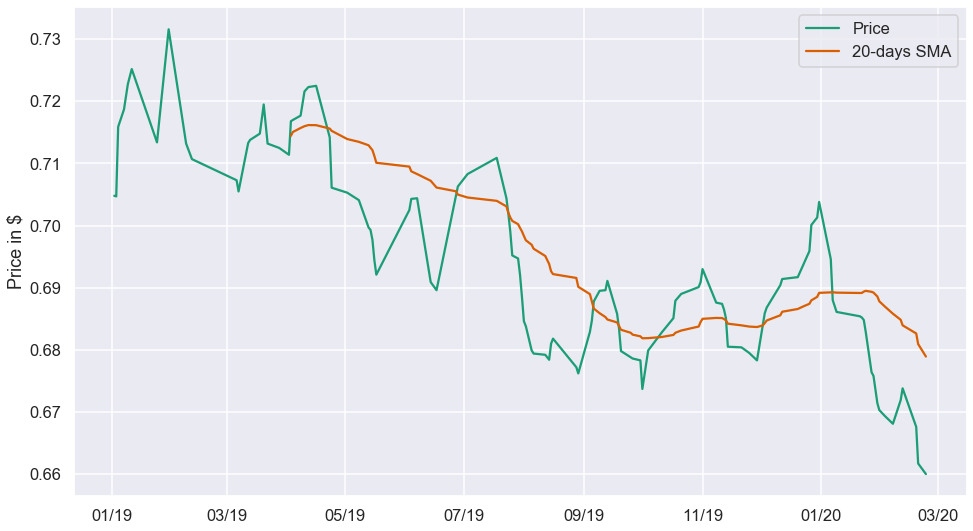

In [148]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'close'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

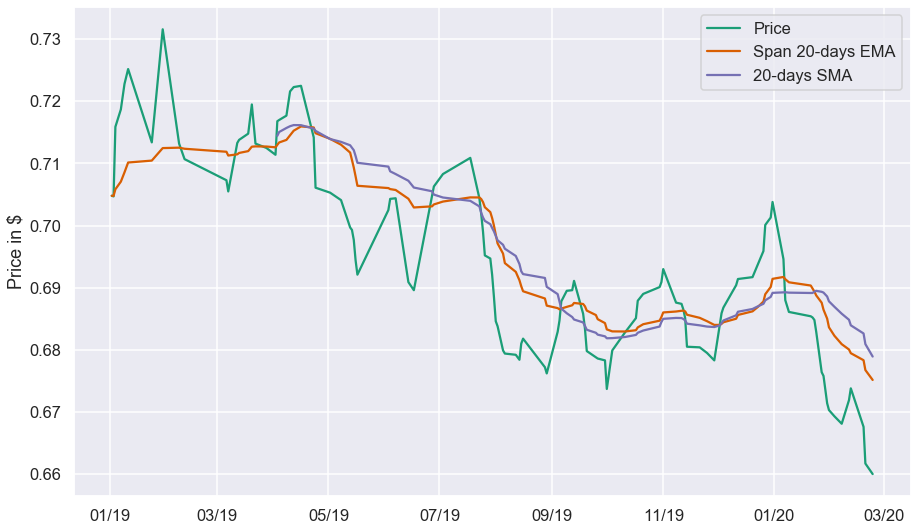

In [149]:
# Using Pandas to calculate a 20-days span EMA. adjust=False specifies that we are interested in the recursive calculation mode.
ema_short = data.ewm(span=20, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15,9))

ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'close'], label = 'Span 20-days EMA')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'close'], label = '20-days SMA')

ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [150]:
# Taking the difference between the prices and the EMA timeseries
trading_positions_raw = data - ema_short
trading_positions_raw.tail()

,close
datetime,
2020-02-10 23:00:00+00:00,-0.008153
2020-02-11 23:00:00+00:00,-0.005658
2020-02-18 23:00:00+00:00,-0.010729
2020-02-19 23:00:00+00:00,-0.015045
2020-02-23 23:00:00+00:00,-0.015150


In [151]:
# Taking the sign of the difference to determine whether the price or the EMA is greater and then multiplying by 1/3
trading_positions = trading_positions_raw.apply(np.sign)
trading_positions.tail()

,close
datetime,
2020-02-10 23:00:00+00:00,-1.0
2020-02-11 23:00:00+00:00,-1.0
2020-02-18 23:00:00+00:00,-1.0
2020-02-19 23:00:00+00:00,-1.0
2020-02-23 23:00:00+00:00,-1.0


In [152]:
# Lagging our trading signals by one day.
trading_positions_final = trading_positions.shift(1)

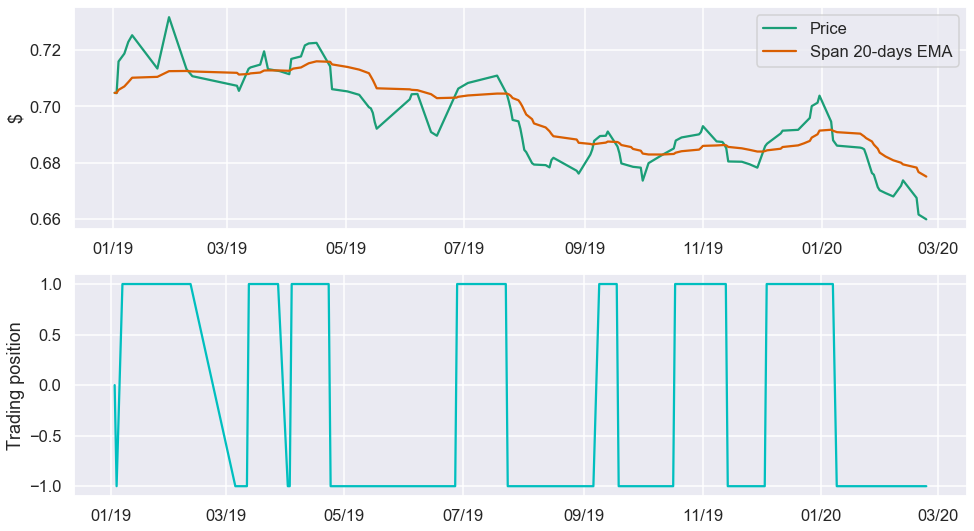

In [153]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, 'close'], label = 'Span 20-days EMA')

ax1.set_ylabel('$')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, 'close'], 
        label='Trading position', color='c')

ax2.set_ylabel('Trading position')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [154]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
asset_log_returns = np.log(data).diff()
asset_log_returns.head()

,close
datetime,
2019-01-01 23:00:00+00:00,NaN
2019-01-02 23:00:00+00:00,-0.000142
2019-01-03 23:00:00+00:00,0.015768
2019-01-06 23:00:00+00:00,0.003904
2019-01-08 23:00:00+00:00,0.005689


In [155]:
strategy_asset_log_returns = trading_positions_final * asset_log_returns
strategy_asset_log_returns.tail()

,close
datetime,
2020-02-10 23:00:00+00:00,-0.005672
2020-02-11 23:00:00+00:00,-0.002824
2020-02-18 23:00:00+00:00,0.009244
2020-02-19 23:00:00+00:00,0.008877
2020-02-23 23:00:00+00:00,0.002572


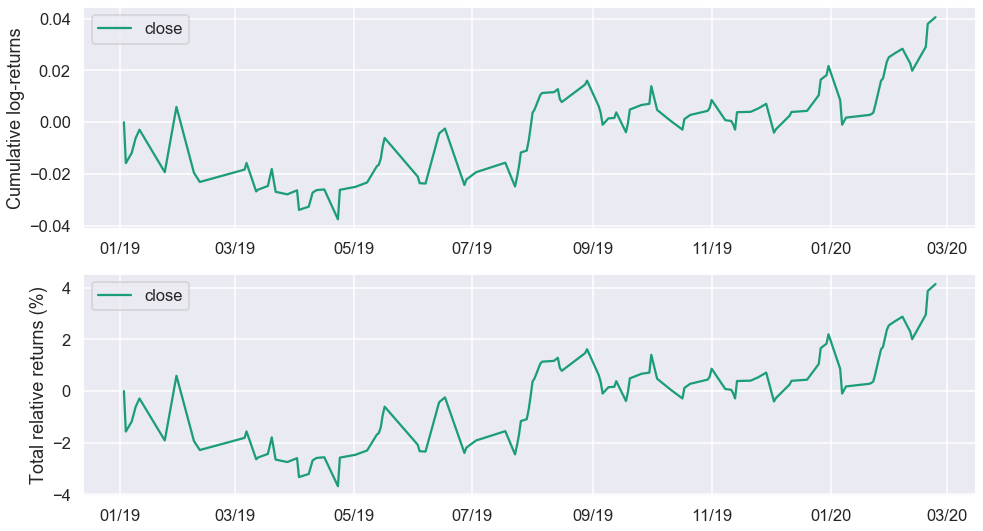

In [156]:
# Get the cumulative log-returns per asset
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

for c in asset_log_returns:
    ax1.plot(cum_strategy_asset_log_returns.index, cum_strategy_asset_log_returns[c], label=str(c))

ax1.set_ylabel('Cumulative log-returns')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

for c in asset_log_returns:
    ax2.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns[c], label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

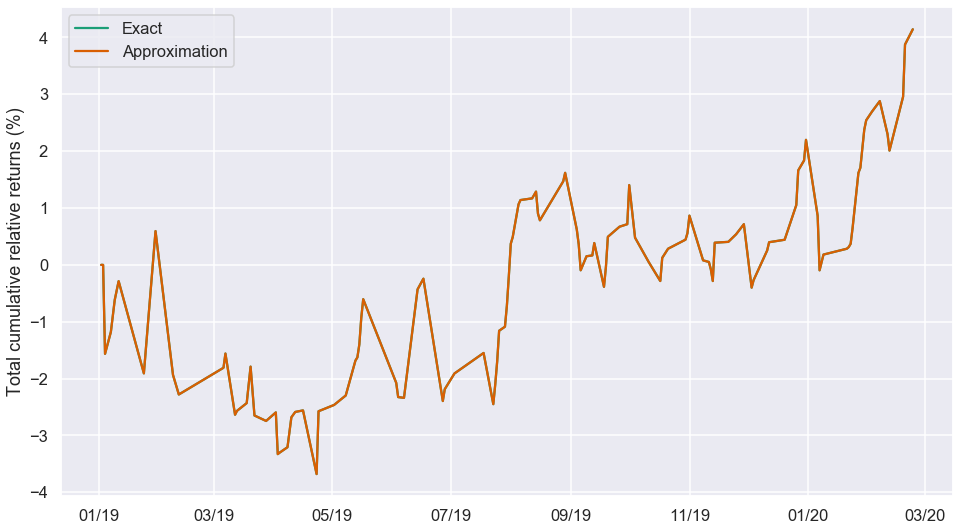

In [157]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_asset_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_asset_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [158]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is:  4.14%
Average yearly return is:  9.36%


Total portfolio return is: -2.17%
Average yearly return is: -4.71%


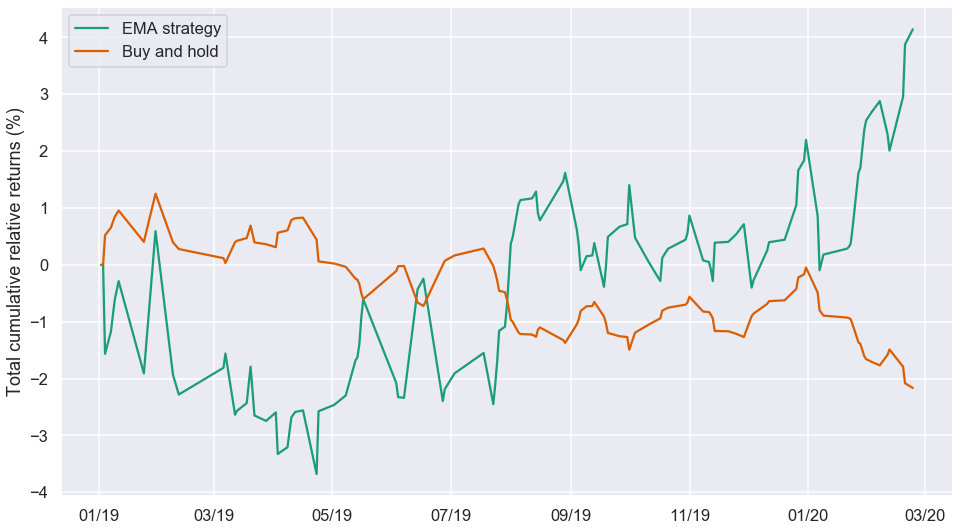

In [159]:
# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = data.index, columns=data.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * asset_log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)